## Overfitting

Given what we learned in the previous lesson about the dangers of omitted variable bias, one might be tempted to throw as many predictors as possible into the model in the hope that "more is always better." Unfortunately, including too many predictors can be just as bad for the quality of our model as including too few. If we include too many irrelevant variables in our model, this may cause *overfitting*. Overfitting occurs when our model becomes distorted by attempting to capture the random noise in our data rather than modeling the true underlying trends.

Recall that two of the major families of tasks that we learned about in our early regression lessons were:

1. Making predictions (ex: predicting sales)
2. Determining parameters (ex: measuring fuel economy)

Overfitting can sabotage our efforts to perform both of these tasks. We will explain why in the following sections.  

## Overfitting: Effect on Predictions

First, we'll look at how overfitting damages our ability to make accurate predictions. Suppose that we are trying to predict sales using advertising spending. Our dataset contains our `sales` and `ad.spend` variables, but also contains the irrelevant variable `music.hits`, which is the number of hit singles released in our country during a given period:

In [1]:
overfitting.df <- read.csv("data/overfitting.csv")
head(overfitting.df)

ad.spend,music.hits,sales
<int>,<int>,<dbl>
10,312,264.71
20,295,370.22
30,306,377.61
40,302,471.30
50,407,700.53
60,305,503.94


Assume that our company sells shovels - we therefore do not expect `music.hits` to have any impact on the sales of our product, as it is not related in any way to our business. For now, therefore, we will just consider a graph of `sales` vs. `ad.spend`:

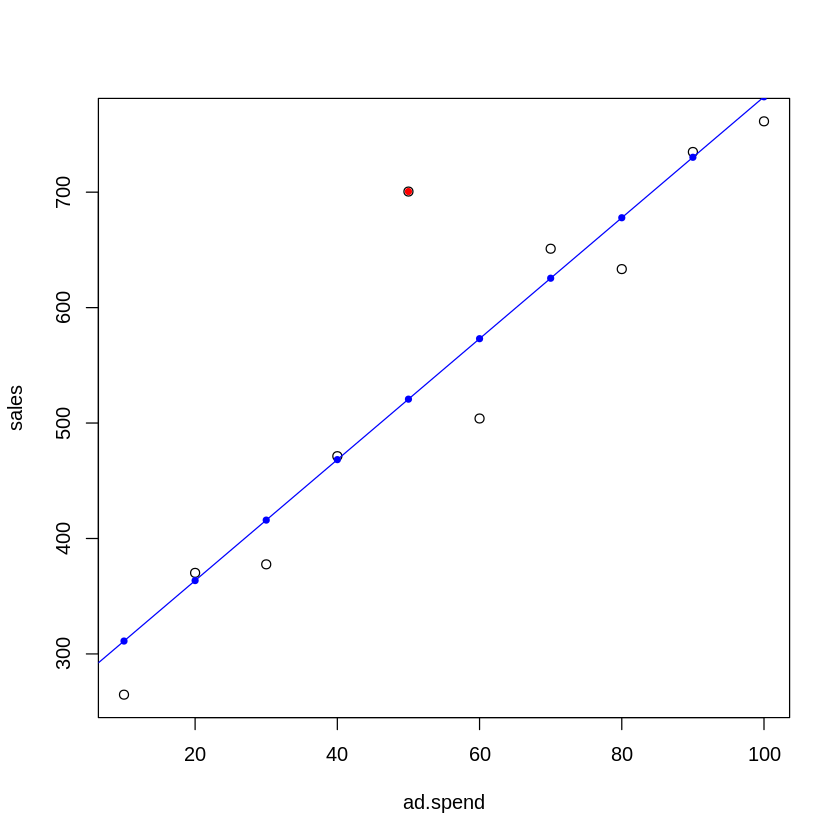

In [2]:
plot(
    sales ~ ad.spend,
    data=overfitting.df
)
points(
    sales ~ ad.spend,
    data=overfitting.df[5,],
    col="red",
    pch=20
)
model <- lm(sales ~ ad.spend, data=overfitting.df)

abline(model, col="blue")
points(
    overfitting.df$ad.spend,
    fitted(model),
    col="blue",
    pch=20
)

In the graph above, we have indicated our model's predictions as blue points. Notice that the red outlier deviates significantly from the trend. This could be due to any number of reasons; perhaps there was a special sale at one of our stores that made our advertising more effective even though we did not spend more.  

Now consider the relationship between `ad.spend` and `music.hits`:

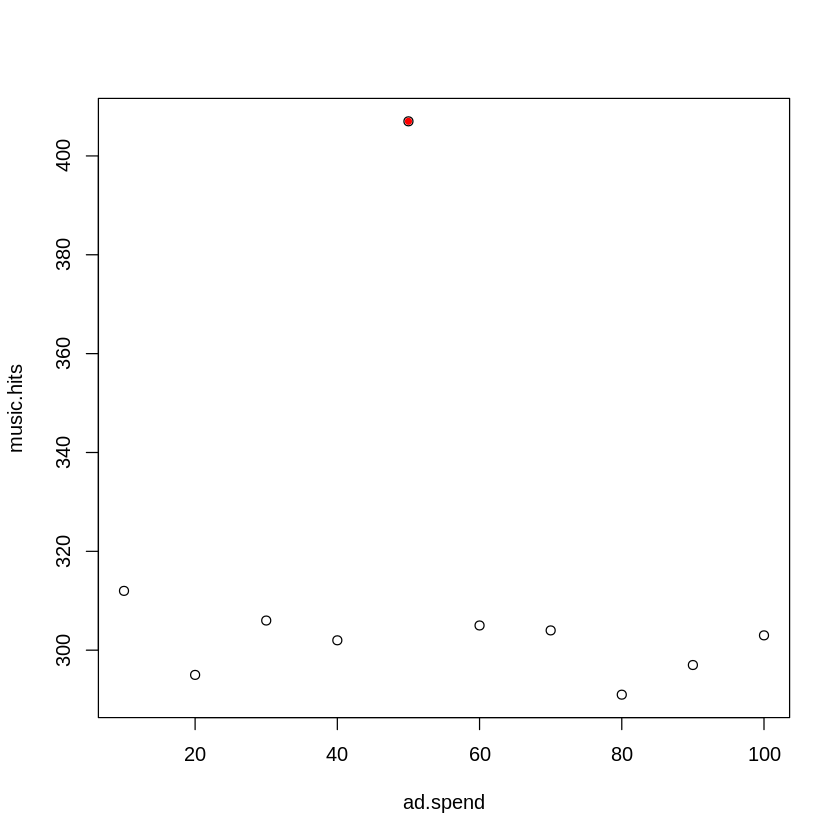

In [3]:
plot(
    music.hits ~ ad.spend,
    data=overfitting.df
)
points(
    overfitting.df$ad.spend[5], 
    overfitting.df$music.hits[5], 
    col="red", 
    pch=20
)

Notice that, purely by coincidence, `music.hits` also has a spike in the same *x* position as the spike in sales - we have highlighted this outlier in red as well.

Let's see what happens when we add `music.hits` as a predictor in our model:

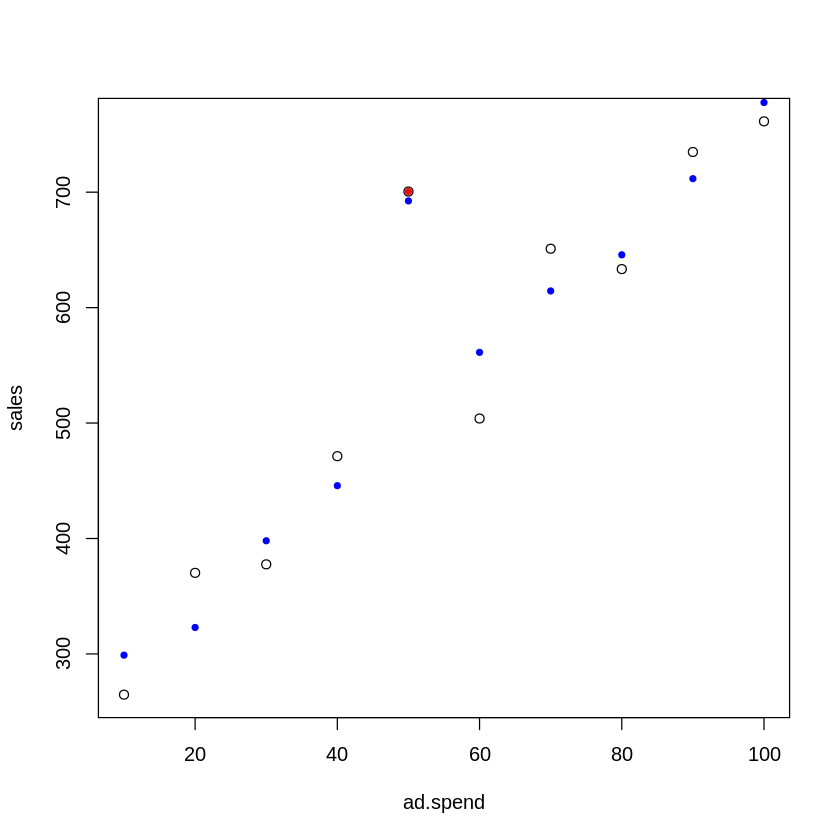

In [4]:
model.overfit <- lm(
    sales ~ ad.spend + music.hits,
    data=overfitting.df
)
plot(
    sales ~ ad.spend,
    data=overfitting.df
)
points(
    sales ~ ad.spend,
    data=overfitting.df[5,],
    col="red",
    pch=20
)
points(
    overfitting.df$ad.spend,
    fitted(model.overfit),
    col="blue",
    pch=20
)

Note that our prediction for the red data point is now much more accurate. Our linear regression has exploited the fact that (purely by coincidence) the spike in `music.hits` aligns with the spike in `sales` - therefore, by "mixing in" a contribution from `music.hits`, it has improved the accuracy of our prediction.

We can therefore see that `music.hits` has been granted a non-zero coefficient in our model:

In [5]:
summary(model.overfit)


Call:
lm(formula = sales ~ ad.spend + music.hits, data = overfitting.df)

Residuals:
    Min      1Q  Median      3Q     Max 
-57.311 -19.388  -2.137  24.951  47.293 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -325.6372   123.6472  -2.634  0.03374 *  
ad.spend       5.5017     0.4221  13.033 3.65e-06 ***
music.hits     1.8255     0.3776   4.834  0.00189 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 38.02 on 7 degrees of freedom
Multiple R-squared:  0.9626,	Adjusted R-squared:  0.9519 
F-statistic: 89.99 on 2 and 7 DF,  p-value: 1.015e-05


This is a classic case of overfitting. Due to coincidental patterns found in the noise from our dataset, our model has "learned" a completely fallacious association. To see how overfitting damages our model's ability to make predictions, consider what happens in the following situation:

* We project an ad spend of `85` for the upcoming year.  
* Musicians in our country go on strike, projecting `music.hits` to zero for the upcoming year. 

Our model's predictions now become completely unreasonable - it predicts a catastrophic drop in sales, even though there is no reason that activity in the music industry should affect sales of shovels:

In [6]:
predict(model.overfit, 
        newdata=data.frame("ad.spend"=85, "music.hits"=0),
        interval="prediction"
)

fit,lwr,upr
142.0078,-150.1353,434.1509


## Overfitting: Effect on Parameters

Overfitting can also corrupt parameters in our model, even those parameters not exclusively associated with the inappropriate variables. For example, look at the `(Intercept)` term in our original model:

In [7]:
coefficients(model)["(Intercept)"]

(Intercept) 
   258.7747

This is a reasonable value that has a clear business interpretation: "Our best guess of how much we would sell if we spend `$0` on ads." Now look at what happens when we corrupt our model through overfitting:

In [8]:
coefficients(model.overfit)["(Intercept)"]

(Intercept) 
  -325.6372

Our intercept now has no clear interpretation because its value has been mangled by the inclusion of `music.hits`.

## Avoiding Overfitting

Our tool of choice for avoiding overfitting is *cross-validation* - specifically, we will use the technique of *Leave-One-Out-Cross-Validation (LOOCV)*. This technique works as follows:

1. Select a candidate model for testing (ex: `sales ~ ad.spend + music.hits`)
2. Remove one point from our dataset.
3. Fit the model on the remaining points.
4. Using this fitted model, predict the *y* value of the removed point. 
5. Calculate the prediction error for the removed point.
6. Repeat the above steps for all other points in the dataset.
7. Combine individual errors to compute Root-Mean-Squared-Error (RMSE) and Mean-Absolute-Error (MAE)

Notice that the cross-validation process described above has separated the actions of *fitting* and *scoring*. This causes cross-validation to *punish* models that overfit and distort themselves to capture noise in our data. Let us examine how this punishment process works by running LOOCV on both the overfit and non-overfit models.

In order to run LOOCV, we'll need the `caret` library:

In [9]:
library(caret)

Loading required package: lattice
Loading required package: ggplot2

Attaching package: ‘caret’

The following object is masked from ‘package:httr’:

    progress



We can then run LOOCV on the overfit model as follows:

In [10]:
model.overfit.cv <- train(
    sales ~ ad.spend + music.hits,
    method="lm",
    data=overfitting.df,
    trControl=trainControl(method="LOOCV")
)
print(model.overfit.cv)

Linear Regression 

10 samples
 2 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 9, 9, 9, 9, 9, 9, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  114.4101  0.6006475  69.09532

Tuning parameter 'intercept' was held constant at a value of TRUE


We can then do the same for the non-overfit model: 

In [11]:
model.cv <- train(
    sales ~ ad.spend,
    method="lm",
    data=overfitting.df,
    trControl=trainControl(method="LOOCV")
)
print(model.cv)

Linear Regression 

10 samples
 1 predictor

No pre-processing
Resampling: Leave-One-Out Cross-Validation 
Summary of sample sizes: 9, 9, 9, 9, 9, 9, ... 
Resampling results:

  RMSE      Rsquared  MAE     
  76.34631  0.78524   52.91577

Tuning parameter 'intercept' was held constant at a value of TRUE


Notice the key result: both the `RMSE` and `MAE` values are significantly lower for the non-overfit model, indicating that it can be expected to generalize better and to give more consistently accurate predictions. LOOCV (and cross-validation more generally) therefore provides us with a *model selection process* for choosing which model we should prefer. The process of LOOCV-based model selection is generally superior to selecting models based on other criteria such as `R-squared` values because LOOCV correctly punishes overfitting.

To see how excatly LOOCV punishes overfitting, consider that if we have $n$ points in the dataset above, the LOOCV process above will include our red outlier point in $n - 1$ fitting steps - the only time the outlier will not be included in the fitting process is when it is removed in step (2) above and used for scoring in step (4) and (5). In the case of our model `sales ~ ad.spend + music.hits`, all of the model parameters for these $n - 1$ fits will be distorted, since our model building function `lm` will try to use `music.hits` to compensate for the red outlier as we discussed above. However, when we *score* each of these $n - 1$ fits in steps (4) and (5), they will score worse when compared to the model `sales ~ ad.spend` that does not include `music.hits` and thus is not distorted by the outlier. Finally, when we fit our model `sales ~ ad.spend + music.hits` and *score* its prediction against the red outlier value, step (2) above excludes the outlier point from the fit and thus prevents the model from exploiting the `music.hits` spike at that point. LOOCV thus erases the "benefits" of overfitting and preserves the downsides, which helps us to select the right model. 

## R-Squared and Overfitting

Notice that the R-squared value has increased substantially when we overfit our model:

In [12]:
summary(model)$r.squared
summary(model.overfit)$r.squared

[1] 0.837565

[1] 0.9625609

This is a general problem; R-squared will *never decrease* when new predictors are added to the model, and in most cases it will *increase* even if the predictor is irrelevant. Therefore, the R-squared value cannot help us to avoid overfitting. 

It is worth mentioning that the `Adjusted R-squared` value shown in the output of `summary(model)` is intended to warn the user of overfitting. `Adjusted R-squared` is computed using a modified R-squared formula that only increases in value when a new predictor improves the fit by an amount "better than chance." 

If adding a new predictor improves `R-squared` but does not improve `Adjusted R-squared`, then it is quite likely that the new predictor is causing overfitting. However, the reverse is not true; an increase in adjusted R-squared does not necessarily mean that the model is not overfitting - for example, including `music.hits` still increases `Adjusted R-squared` substantially:

In [13]:
summary(model)$adj.r.squared
summary(model.overfit)$adj.r.squared

[1] 0.8172607

[1] 0.9518641

Therefore, cross-validation should be preferred for detecting overfitting.

## Beyond LOOCV

The concept of cross-validation is more general than the LOOCV procedure discussed above. In the general "$k$-fold cross-validation" procedure, we randomly divide our dataset into $k$ evenly-sized subsamples or "folds." For each fold, we train our model on the *other* folds and then evaluate the accuracy of its predictions on the current fold. All of these accuracy numbers are then averaged together to yield an overall "score" for the model. The most common choices of $k$ are `5` and `10`. We'll need a dataset with more data points to run $k$-fold cross validation, so let's load one of our earlier datasets:

In [14]:
ovb.df <- read.csv("data/omitted-variable-bias.csv")
head(ovb.df)

monthly.social.media.posts,years.experience,annual.salary
<int>,<int>,<int>
148,11,100
260,6,96
106,12,96
27,21,150
170,12,91
120,14,131


We can assess the performance of the model `annual.salary ~ monthly.social.media.posts + years.experience` by running 3-fold cross validation using the following code:

In [15]:
model.3.fold.cv <- train(
    annual.salary ~ monthly.social.media.posts + years.experience,
    method="lm",
    data=ovb.df,
    trControl=trainControl(method="cv", number=3)
)
print(model.3.fold.cv)

Linear Regression 

50 samples
 2 predictor

No pre-processing
Resampling: Cross-Validated (3 fold) 
Summary of sample sizes: 33, 32, 35 
Resampling results:

  RMSE      Rsquared   MAE     
  16.97527  0.4403003  14.81128

Tuning parameter 'intercept' was held constant at a value of TRUE


<span style="color:blue;font-weight:bold">Exercise</span>: Use the `train` function as shown above to perform 5-fold cross-validation on the model `annual.salary ~ monthly.social.media.posts` - assign your result to the variable `model.5.fold`

In [17]:
# delete this entire line and replace it with your code

model.5.fold <- train(
    annual.salary ~ monthly.social.media.posts,
    method='lm',
    data=ovb.df,
    trControl=trainControl(method='cv', number=5)
)


In [18]:
check.variable.definition("model.5.fold")
assert.true(round(coefficients(model.5.fold$finalModel)['monthly.social.media.posts'], 2) == -0.15, "Did you set <code>model.5.fold</code> correctly?")
correct.model.5.fold <- train(
    annual.salary ~ monthly.social.media.posts,
    method="lm",
    data=ovb.df,
    trControl=trainControl(method="cv", number=5)
)
success()

Correct!

In [18]:
model.5.fold

Linear Regression 

50 samples
 1 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 40, 39, 40, 40, 41 
Resampling results:

  RMSE      Rsquared   MAE     
  19.99601  0.2937246  15.93212

Tuning parameter 'intercept' was held constant at a value of TRUE

In [19]:
str(model.5.fold)

List of 23
 $ method      : chr "lm"
 $ modelInfo   :List of 13
  ..$ label     : chr "Linear Regression"
  ..$ library   : NULL
  ..$ loop      : NULL
  ..$ type      : chr "Regression"
  ..$ parameters:'data.frame':	1 obs. of  3 variables:
  .. ..$ parameter: chr "intercept"
  .. ..$ class    : chr "logical"
  .. ..$ label    : chr "intercept"
  ..$ grid      :function (x, y, len = NULL, search = "grid")  
  .. ..- attr(*, "srcref")= 'srcref' int [1:8] 8 26 9 48 26 48 8 9
  .. .. ..- attr(*, "srcfile")=Classes 'srcfilecopy', 'srcfile' <environment: 0x55fe29f0c1c0> 
  ..$ fit       :function (x, y, wts, param, lev, last, classProbs, ...)  
  .. ..- attr(*, "srcref")= 'srcref' int [1:8] 10 25 27 19 25 19 10 27
  .. .. ..- attr(*, "srcfile")=Classes 'srcfilecopy', 'srcfile' <environment: 0x55fe29f0c1c0> 
  ..$ predict   :function (modelFit, newdata, submodels = NULL)  
  .. ..- attr(*, "srcref")= 'srcref' int [1:8] 28 29 31 19 29 19 28 31
  .. .. ..- attr(*, "srcfile")=Classes 'srcfilec

In [20]:
summary(model.5.fold)


Call:
lm(formula = .outcome ~ ., data = dat)

Residuals:
    Min      1Q  Median      3Q     Max 
-47.357 -13.273  -1.786  12.450  37.704 

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                116.64766    6.73662  17.315  < 2e-16 ***
monthly.social.media.posts  -0.15310    0.04025  -3.804 0.000403 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 19.96 on 48 degrees of freedom
Multiple R-squared:  0.2316,	Adjusted R-squared:  0.2156 
F-statistic: 14.47 on 1 and 48 DF,  p-value: 0.0004028
